In [1]:
DATA_DIR = "/kaggle/input/hajj-4/My First Project.v4i.folder"  

In [2]:
import os, random, math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
density_map = {"Low": 0.2, "medium": 0.5, "High": 0.8}
class_order = ["Low", "medium", "High"]  # keep consistent everywhere

class CrowdDensityDataset(Dataset):
    def __init__(self, root_dir, transform=None, allowed_ext=(".jpg",".jpeg",".png",".bmp",".webp")):
        self.samples = []
        self.transform = transform
        for cls in class_order:
            folder = os.path.join(root_dir, cls)
            if not os.path.isdir(folder):
                continue
            for fn in os.listdir(folder):
                if fn.lower().endswith(allowed_ext):
                    self.samples.append((os.path.join(folder, fn), float(density_map[cls]), cls))
        if len(self.samples) == 0:
            raise ValueError(f"No images found in {root_dir}. Check your path/structure.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, y, cls = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        y = torch.tensor([y], dtype=torch.float32)  # shape (1,)
        return img, y, cls, img_path


In [4]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_ds = CrowdDensityDataset(os.path.join(DATA_DIR, "train"), transform=train_tf)
valid_ds = CrowdDensityDataset(os.path.join(DATA_DIR, "valid"), transform=eval_tf)
test_ds  = CrowdDensityDataset(os.path.join(DATA_DIR, "test"),  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("Train:", len(train_ds), "Valid:", len(valid_ds), "Test:", len(test_ds))


Train: 3627 Valid: 442 Test: 419


In [5]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)  # regression output
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


In [6]:
def eval_regression(loader):
    model.eval()
    ys, preds, paths = [], [], []
    with torch.no_grad():
        for x, y, cls, img_path in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            ys.append(y.cpu().numpy().reshape(-1))
            preds.append(out.cpu().numpy().reshape(-1))
            paths += list(img_path)
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return mae, mse, y_true, y_pred, paths

epochs = 10
best_val_mae = float("inf")

history = {"train_loss": [], "val_mae": [], "val_mse": []}

for epoch in range(1, epochs+1):
    model.train()
    running = 0.0
    for x, y, cls, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running += loss.item()

    train_loss = running / max(1, len(train_loader))
    val_mae, val_mse, *_ = eval_regression(valid_loader)

    history["train_loss"].append(train_loss)
    history["val_mae"].append(val_mae)
    history["val_mse"].append(val_mse)

    print(f"Epoch {epoch}: train_loss={train_loss:.5f} | val_MAE={val_mae:.5f} | val_MSE={val_mse:.5f}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), "stage2_best_resnet18_density.pth")
        print("✅ Saved best model")


Epoch 1/10: 100%|██████████| 114/114 [00:15<00:00,  7.33it/s]


Epoch 1: train_loss=0.04818 | val_MAE=0.14756 | val_MSE=0.03527
✅ Saved best model


Epoch 2/10: 100%|██████████| 114/114 [00:11<00:00,  9.77it/s]


Epoch 2: train_loss=0.01282 | val_MAE=0.13781 | val_MSE=0.02670
✅ Saved best model


Epoch 4/10: 100%|██████████| 114/114 [00:10<00:00, 10.39it/s]


Epoch 4: train_loss=0.00643 | val_MAE=0.08092 | val_MSE=0.01084


Epoch 5/10: 100%|██████████| 114/114 [00:11<00:00, 10.30it/s]


Epoch 5: train_loss=0.00510 | val_MAE=0.04260 | val_MSE=0.00466
✅ Saved best model


Epoch 6/10: 100%|██████████| 114/114 [00:11<00:00, 10.24it/s]


Epoch 6: train_loss=0.00459 | val_MAE=0.12161 | val_MSE=0.01694


Epoch 7/10: 100%|██████████| 114/114 [00:10<00:00, 10.49it/s]


Epoch 7: train_loss=0.00379 | val_MAE=0.07431 | val_MSE=0.00875


Epoch 8/10: 100%|██████████| 114/114 [00:11<00:00, 10.12it/s]


Epoch 8: train_loss=0.00293 | val_MAE=0.04324 | val_MSE=0.00406


Epoch 9/10: 100%|██████████| 114/114 [00:11<00:00, 10.02it/s]


Epoch 9: train_loss=0.00255 | val_MAE=0.04077 | val_MSE=0.00465
✅ Saved best model


Epoch 10/10: 100%|██████████| 114/114 [00:11<00:00, 10.14it/s]


Epoch 10: train_loss=0.00276 | val_MAE=0.05927 | val_MSE=0.00603


In [8]:
def density_to_class(v):
    # thresholds between 0.2 / 0.5 / 0.8 (midpoints)
    if v < 0.35: return "Low"
    if v < 0.65: return "medium"
    return "High"


In [9]:
# Load best
model.load_state_dict(torch.load("stage2_best_resnet18_density.pth", map_location=device))
model.eval()

test_mae, test_mse, y_true, y_pred, paths = eval_regression(test_loader)
print("TEST  MAE:", test_mae, "MSE:", test_mse)

# Convert to classes
true_cls = [density_to_class(v) for v in y_true]
pred_cls = [density_to_class(v) for v in y_pred]


TEST  MAE: 0.032438725 MSE: 0.0018285132


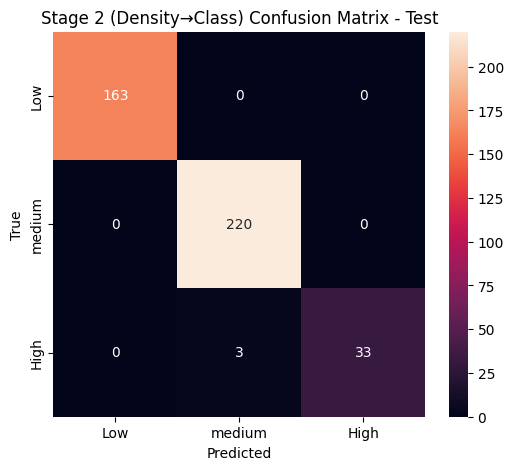

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       163
      medium       0.99      1.00      0.99       220
        High       1.00      0.92      0.96        36

    accuracy                           0.99       419
   macro avg       1.00      0.97      0.98       419
weighted avg       0.99      0.99      0.99       419



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["Low","medium","High"]
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Stage 2 (Density→Class) Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(true_cls, pred_cls, labels=labels))


In [11]:
def smooth_series(arr, window=15):
    arr = np.asarray(arr, dtype=float)
    out = np.zeros_like(arr)
    for i in range(len(arr)):
        s = max(0, i-window+1)
        out[i] = arr[s:i+1].mean()
    return out


In [12]:
robust_tests = {
    "clean": eval_tf,
    "dark": transforms.Compose([transforms.Resize((224,224)), transforms.ColorJitter(brightness=0.6), transforms.ToTensor()]),
    "blur": transforms.Compose([transforms.Resize((224,224)), transforms.GaussianBlur(7), transforms.ToTensor()]),
    "low_res": transforms.Compose([transforms.Resize((112,112)), transforms.Resize((224,224)), transforms.ToTensor()]),
}

rows = []
for name, tfm in robust_tests.items():
    ds = CrowdDensityDataset(os.path.join(DATA_DIR, "test"), transform=tfm)
    loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    mae, mse, *_ = eval_regression(loader)
    rows.append({"setting": name, "MAE": mae, "MSE": mse})

robust_df = pd.DataFrame(rows).sort_values("MAE")
robust_df


,setting,MAE,MSE
0,clean,0.032439,0.001829
1,dark,0.038909,0.002848
2,blur,0.050146,0.004252
3,low_res,0.057411,0.004724


In [13]:
out_df = pd.DataFrame({
    "img_path": paths,
    "y_true_density": y_true,
    "y_pred_density": y_pred,
    "y_true_class": true_cls,
    "y_pred_class": pred_cls,
})
out_df.to_csv("stage2_test_predictions.csv", index=False)
print("Saved stage2_test_predictions.csv")


Saved stage2_test_predictions.csv


In [14]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)

model.load_state_dict(
    torch.load("stage2_best_resnet18_density.pth", map_location=device)
)
model = model.to(device)
model.eval()

print("Stage 2 density model loaded")


Stage 2 density model loaded


In [15]:
import cv2
from PIL import Image

def predict_density_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(frame_rgb)
    img = eval_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        density = model(img).item()

    return float(density)


In [16]:
input_video = "/kaggle/input/hajjv2/HAJJv2.Dataset/Testing/Videos/3.mp4"   # <-- change
output_video = "density_output_raw.mp4"

cap = cv2.VideoCapture(input_video)
fps = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video, fourcc, fps, (W, H))

frame_id = 0
densities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    d = predict_density_frame(frame)
    densities.append(d)

    cv2.putText(
        frame,
        f"Density: {d:.2f}",
        (30, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0, 255, 0),
        3,
    )

    out.write(frame)
    frame_id += 1

cap.release()
out.release()

print("Video processed:", output_video)
print("Total frames:", len(densities))


Video processed: density_output_raw.mp4
Total frames: 492


In [18]:
import numpy as np

def temporal_smooth(arr, window=15):
    smoothed = []
    for i in range(len(arr)):
        start = max(0, i - window + 1)
        smoothed.append(np.mean(arr[start:i+1]))
    return np.array(smoothed)

densities_smooth = temporal_smooth(densities, window=15)


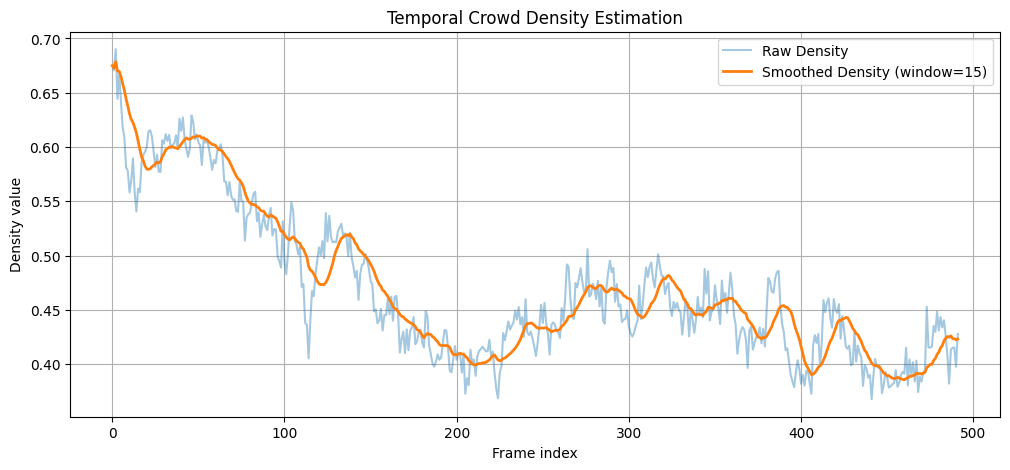

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(densities, label="Raw Density", alpha=0.4)
plt.plot(densities_smooth, label="Smoothed Density (window=15)", linewidth=2)
plt.xlabel("Frame index")
plt.ylabel("Density value")
plt.title("Temporal Crowd Density Estimation")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import pandas as pd

df_video = pd.DataFrame({
    "frame": np.arange(len(densities)),
    "density_raw": densities,
    "density_smooth": densities_smooth,
})

df_video.to_csv("video_density_timeline.csv", index=False)
print("Saved video_density_timeline.csv")


Saved video_density_timeline.csv


In [23]:
def density_to_class(v):
    if v < 0.35: return "Low"
    if v < 0.65: return "medium"
    return "High"

df_video["label"] = df_video["density_smooth"].apply(density_to_class)
df_video.head()


,frame,density_raw,density_smooth,label
0,0,0.674897,0.674897,High
1,1,0.670678,0.672788,High
2,2,0.690049,0.678541,High
3,3,0.644329,0.669988,High
4,4,0.668617,0.669714,High


In [ ]:
from IPython.display import Video

Video("/kaggle/working/density_output_raw.mp4", embed=True, width=700)


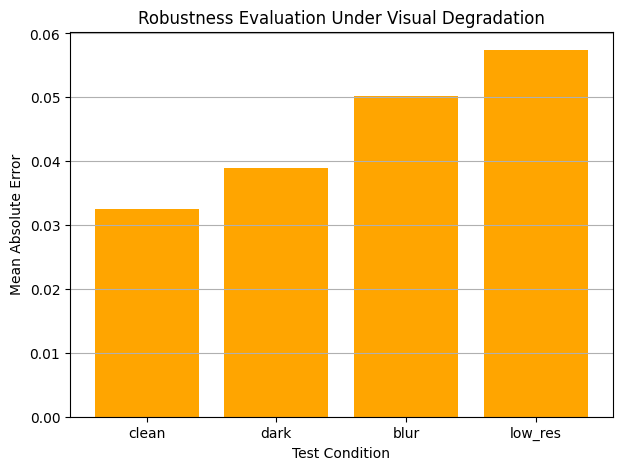

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(robust_df["setting"], robust_df["MAE"], color="orange")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Test Condition")
plt.title("Robustness Evaluation Under Visual Degradation")
plt.grid(axis="y")
plt.savefig("robustness_mae.png", dpi=300)
plt.show()


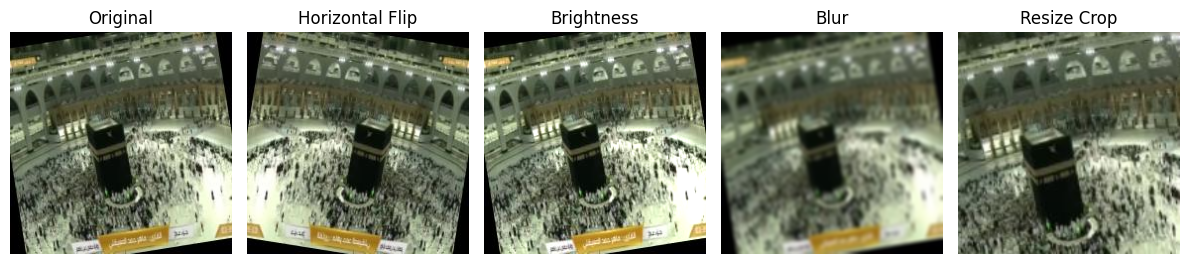

In [34]:
import os
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ---- DEFINE TRAIN DIRECTORY ----
train_dir = "/kaggle/input/hajj-4/My First Project.v4i.folder/train"  
# ⬆️ change this path ONLY if your train folder is elsewhere

# ---- PICK RANDOM CLASS ----
class_name = random.choice(os.listdir(train_dir))
class_dir = os.path.join(train_dir, class_name)

# ---- PICK RANDOM IMAGE ----
img_name = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, img_name)

img = Image.open(img_path).convert("RGB")

# ---- DEFINE AUGMENTATIONS ----
augmentations = {
    "Original": transforms.ToTensor(),
    "Horizontal Flip": transforms.RandomHorizontalFlip(p=1.0),
    "Brightness": transforms.ColorJitter(brightness=0.5),
    "Blur": transforms.GaussianBlur(kernel_size=7),
    "Resize Crop": transforms.RandomResizedCrop(224)
}

# ---- VISUALIZE ----
plt.figure(figsize=(12,6))

for i, (name, aug) in enumerate(augmentations.items()):
    aug_img = aug(img)
    if not isinstance(aug_img, Image.Image):
        aug_img = transforms.ToPILImage()(aug_img)

    plt.subplot(1, len(augmentations), i+1)
    plt.imshow(aug_img)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.savefig("augmentation_examples.png", dpi=300)
plt.show()


In [35]:
print("Train:", len(train_loader.dataset))
print("Valid:", len(valid_loader.dataset))
print("Test:",  len(test_loader.dataset))

Train: 3627
Valid: 442
Test: 419
